<a href="https://colab.research.google.com/github/NicolaGabriele/powerline_Segmentation_project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
TRAIN_DIR = '/content/drive/MyDrive/trainingset'
TEST_DIR = '/content/drive/MyDrive/testset'

In [ ]:
class PowerLineTrainDataset(torch.utils.data.Dataset):
  def __init__(self,img_dir):
    self.img_dir = img_dir

  def __get_item__(self,id):
    l = os.listdir(self.img_dir)
    path = os.path.join(self.img_dir, l[id])
    image = torchvision.io.read_image(path)
    return image

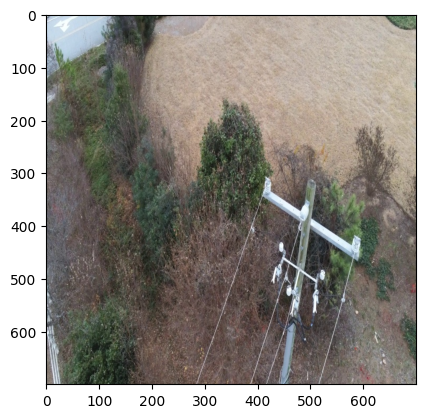

In [19]:
%matplotlib inline
l = os.listdir(TRAIN_DIR)
path = os.path.join(TRAIN_DIR, l[0])
image = matplotlib.image.imread(path)
plt.imshow(image)